In [1]:
#Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb          
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")
import kagglehub
from kagglehub import KaggleDatasetAdapter


In [2]:
#Load & inspect data
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
display(df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


None

In [3]:
#Train/test split
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [4]:
# Define model + param grids
models = {
    "log_reg": (
        LogisticRegression(max_iter=500),
        {"log_reg__C": np.logspace(-3, 3, 7)}
    ),
    "knn": (
        KNeighborsClassifier(),
        {"knn__n_neighbors": range(3, 31, 2)}
    ),
    "dt": (
        DecisionTreeClassifier(),
        {"dt__max_depth": range(1, 15)}
    ),
    "rf": (
        RandomForestClassifier(),
        {"rf__n_estimators": [100, 300, 500],
         "rf__max_depth": [None, 5, 10]}
    ),
    "gb": (
        GradientBoostingClassifier(),
        {"gb__n_estimators": [100, 300],
         "gb__learning_rate": [0.01, 0.1, 0.2]}
    ),
    "svm": (
        SVC(probability=True),
        {"svm__C": [0.1, 1, 10],
         "svm__gamma": ["scale", 0.001, 0.01]}
    ),
    "xgb": (
        xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        {"xgb__n_estimators": [200, 400],
         "xgb__max_depth": [3, 5],
         "xgb__learning_rate": [0.05, 0.1]}
    )
}


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Identify categorical and numeric features
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessing for both types
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

results = []

# Model training + tuning loop
for name, (estimator, param_grid) in models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        (name, estimator)
    ])

    if len(param_grid) <= 8:
        search = GridSearchCV(pipe, param_grid, cv=5, scoring="f1", n_jobs=-1)
    else:
        search = RandomizedSearchCV(pipe, param_grid, n_iter=20, cv=5, scoring="f1", n_jobs=-1)

    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)

    results.append({
        "model": name.upper(),
        "best_params": search.best_params_,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    })

# View results
results_df = pd.DataFrame(results).sort_values(by="f1_score", ascending=False)
results_df

,model,best_params,accuracy,precision,recall,f1_score
4,GB,"{'gb__learning_rate': 0.01, 'gb__n_estimators'...",0.907609,0.889908,0.950980,0.919431
1,KNN,{'knn__n_neighbors': 17},0.902174,0.903846,0.921569,0.912621
3,RF,"{'rf__max_depth': 5, 'rf__n_estimators': 300}",0.896739,0.880734,0.941176,0.909953
5,SVM,"{'svm__C': 1, 'svm__gamma': 'scale'}",0.896739,0.887850,0.931373,0.909091
0,LOG_REG,{'log_reg__C': 0.1},0.891304,0.879630,0.931373,0.904762
6,XGB,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.885870,0.900990,0.892157,0.896552
2,DT,{'dt__max_depth': 3},0.820652,0.870968,0.794118,0.830769


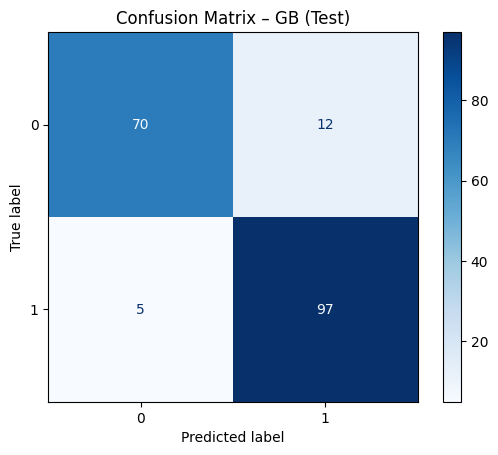

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])
# Extract best model name and clean parameters
best_model_name = results_df.iloc[0]["model"].lower()
base_model, _ = models[best_model_name]
clean_params = {
    key.split("__")[1]: val
    for key, val in results_df.iloc[0]["best_params"].items()
}
# Rebuild final pipeline with correct preprocessing
best_pipe = Pipeline([
    ("pre", preprocessor),
    (best_model_name, base_model.set_params(**clean_params))
])
# Fit and display confusion matrix
best_pipe.fit(X_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(
    best_pipe, X_test, y_test, cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix – {best_model_name.upper()} (Test)")
plt.show()

In [7]:
# Save model
import joblib, json, os, datetime as dt
os.makedirs("/kaggle/working/model", exist_ok=True)
joblib.dump(best_pipe, "/kaggle/working/model/heart_failure_clf.joblib")
results_df.to_csv("/kaggle/working/model/metrics.csv", index=False)
print("Best model saved")

Best model saved


,model,best_params,accuracy,precision,recall,f1_score
0,GB,"{'gb__learning_rate': 0.01, 'gb__n_estimators'...",0.907609,0.889908,0.950980,0.919431
1,KNN,{'knn__n_neighbors': 17},0.902174,0.903846,0.921569,0.912621
2,RF,"{'rf__max_depth': 5, 'rf__n_estimators': 300}",0.896739,0.880734,0.941176,0.909953
3,SVM,"{'svm__C': 1, 'svm__gamma': 'scale'}",0.896739,0.887850,0.931373,0.909091
4,LOG_REG,{'log_reg__C': 0.1},0.891304,0.879630,0.931373,0.904762
5,XGB,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",0.885870,0.900990,0.892157,0.896552
6,DT,{'dt__max_depth': 3},0.820652,0.870968,0.794118,0.830769


<Axes: xlabel='model', ylabel='F1‑score'>

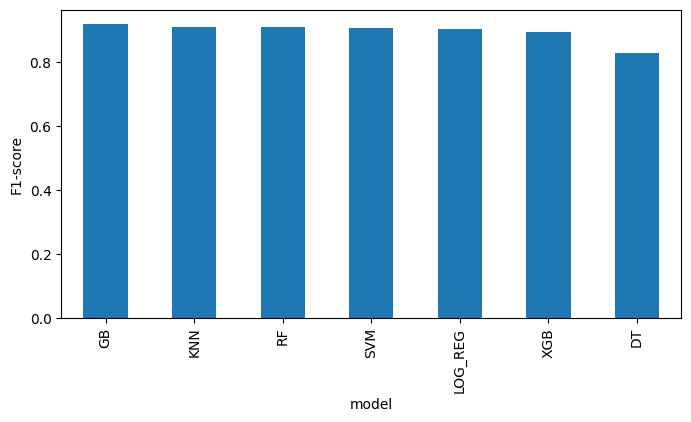

In [8]:
#View the saved metrics
import pandas as pd

metrics_path = "/kaggle/working/model/metrics.csv"
metrics_df = pd.read_csv(metrics_path)
metrics_df = metrics_df.sort_values("f1_score", ascending=False).reset_index(drop=True)
display(metrics_df)         
metrics_df.plot.bar(x="model", y="f1_score", figsize=(8,4), legend=False, ylabel="F1‑score")